In [8]:
library(gdata)
library(ggplot2)
library(grid)
library(gridExtra)

In [9]:
DT <- read.table("../Data/All_data.txt")

In [10]:
ratio_align <- read.table("../Data/Alignment_ratios_within_regions_across_diseases_wt_sims_patients_metrs_burdens.txt")

In [11]:
DT$Dis_lab <- DT$Disease
levels(DT$Disease)

[1] "All"                                                                                     
 [2] "Cardiovascular and circulatory diseases"                                                 
 [3] "Chronic respiratory diseases"                                                            
 [4] "Cirrhosis of the liver"                                                                  
 [5] "Congenital anomalies"                                                                    
 [6] "Diabetes, urinary diseases and male infertility"                                         
 [7] "Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases"
 [8] "Digestive diseases (except cirrhosis)"                                                   
 [9] "Gynecological diseases"                                                                  
[10] "Hemoglobinopathies and hemolytic anemias"                                                
[11] "Hepatitis"                                                                               
[12] "HIV/AIDS"                                                                                
[13] "Leprosy"                                                                                 
[14] "Malaria"                                                                                 
[15] "Maternal disorders"                                                                      
[16] "Mental and behavioral disorders"                                                         
[17] "Musculoskeletal disorders"                                                               
[18] "Neglected tropical diseases excluding malaria"                                           
[19] "Neonatal disorders"                                                                      
[20] "Neoplasms"                                                                               
[21] "Neurological disorders"                                                                  
[22] "Nutritional deficiencies"                                                                
[23] "Oral disorders"                                                                          
[24] "Sense organ diseases"                                                                    
[25] "Sexually transmitted diseases excluding HIV"                                             
[26] "Skin and subcutaneous diseases"                                                          
[27] "Sudden infant death syndrome"                                                            
[28] "Tuberculosis"

In [12]:
#Disease labels for plot
DT$Dis_lab <- DT$Disease
levels(DT$Dis_lab) <- c("",
               "Cardiovasc.\nand circulatory",
               "Chronic\nrespiratory",
               "Cirrhosis",
               "Congenital\nanomalies",
               "Diabetes, urinary\nmale infertility",
               "Common\ninfections",
               "Digestive",
               "Gynecol.",
               "Hemoglob. and\nhemolytic anemia",
               "Hepatitis",
               "HIV",
               "Leprosy",
               "Malaria",
               "Maternal\ndisorders",
               "Mental and\nbehavioral",
               "Musculosk.",
               "Neglected trop.",
               "Neonatal\ndisorders",
               "Neoplasms",
               "Neurological",
               "Nutritional",
               "Oral",
               "Sense organ",
               "STD",
               "Skin and\nsubcutaneous",
               "Sudden infant death",
               "Tuberculosis")

In [22]:
#Order of regions: decreasing nb of RCTs
rt <- DT[DT$Disease=="All" & !DT$Region%in%c("Non-HI"),]
regs <- as.character(rt$Region[order(rt$Nb_RCTs_med,decreasing=TRUE)])
regs

[1] "All"                                             
[2] "High-income"                                     
[3] "Southeast Asia, East Asia and Oceania"           
[4] "North Africa and Middle East"                    
[5] "Central Europe, Eastern Europe, and Central Asia"
[6] "South Asia"                                      
[7] "Latin America and Caribbean"                     
[8] "Sub-Saharian Africa"

In [23]:
#For annotating with ratio of alignment
form <- function(x){
paste(format(round(x[2]),nsmall = 0),
           "% [",format(round(x[1]),nsmall = 0),
           "-",format(round(x[3]),nsmall = 0),"]",sep="")
    }

In [34]:
metr_burden <- "death"
metr_res <- "RCTs"
max_plot <- 70

In [35]:
L <- list()
for(i in 1:length(regs)){

    r <- regs[i]
    
    dtp <- DT[DT$Region==r & DT$Disease!="All",c(which(names(DT)%in%c("Disease","Dis_lab")),
                        intersect(grep(metr_burden,names(DT)),grep("Prop_loc_burden",names(DT))),
                        intersect(grep(metr_res,names(DT)),grep("Prop_loc_",names(DT)))),]
    
    dfb <- dtp[,c(1,2,3)]
    names(dfb) <- c("Disease","Dis_lab","prop")
    dfb$mes <- "burden"
    dfr <- dtp[,c(1,2,5)]
    names(dfr) <- c("Disease","Dis_lab","prop")
    dfr$mes <- "research"
    dt <- rbind(dfb,dfr)

    dfre <- dtp[,c(1,2,4,6)]
    names(dfre) <- c("Disease","Dis_lab","prop_low","prop_up")
    dfre$mes <- "research"
    
    #10 Principales maladies
    diss <- dfb$Disease[order(dfb$prop,decreasing=TRUE)][1:10]
    dt <- droplevels(dt[dt$Disease%in%diss,])
    dfre <- droplevels(dfre[dfre$Disease%in%diss,])
    #Order of diseases
    dt$Disease <- reorder(dt$Disease,new.order=as.character(diss))
    dfre$Disease <- reorder(dfre$Disease,new.order=as.character(diss))
    
    #Highlighting GAPS
    dt$gap <- dt$Disease
    levels(dt$gap) <- unlist(lapply(levels(dt$Disease),
                                    function(x){
                                        ifelse(sum(dfre$Disease==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Disease==x]/
                                        dfre$prop_up[dfre$Disease==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Disease),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    #GGPLOT Object
    p <- ggplot(dt,aes(Disease))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Disease)-0.4,xend=as.numeric(Disease)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Disease)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Dis_lab
                              )

    if(i%%3==1){
    p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("Local proportion of\n",
                                           ifelse(metr_burden=="death",metr_burden,toupper(metr_burden)),
                                           " and ",
                                           metr_res,
                                           " (%)",sep="")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("\n")
                                )
        }
    p <- p + ggtitle(r)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(diss)+1)/2,y=max_plot-5,label=
            paste("R =",
             form(ratio_align[ratio_align$Region==r & ratio_align$metr==metr_burden,paste(metr_res,"nogap",sep="_")]))
            )
    
    L[[i]] <- p
}

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

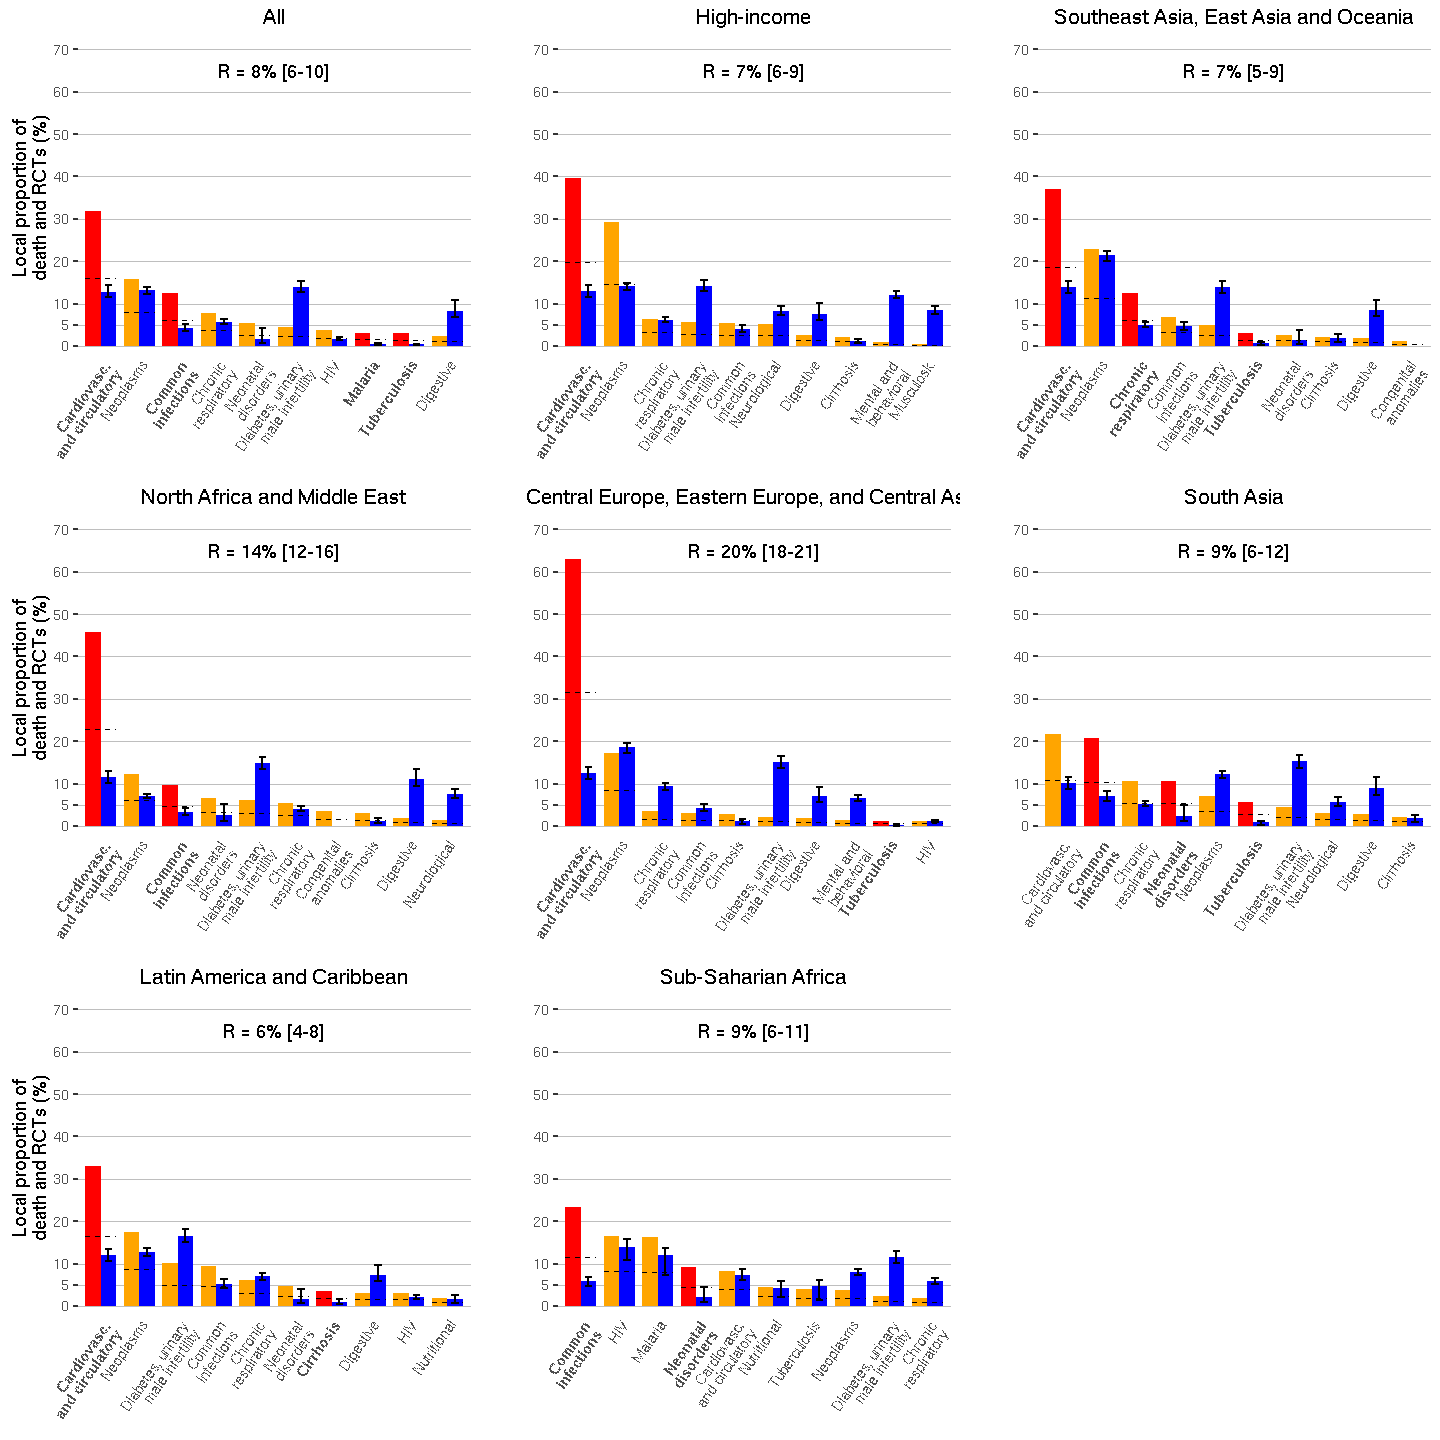

In [36]:
options(repr.plot.width=12, repr.plot.height=12)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3)

In [37]:
ggsave(filename = "../Figures/RCTs_vs_death_allregions.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3),
       width=12,height=12)

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

In [43]:
metr_burden <- "yll"
metr_res <- "RCTs"
max_plot <- 50

In [44]:
L <- list()
for(i in 1:length(regs)){

    r <- regs[i]
    
    dtp <- DT[DT$Region==r & DT$Disease!="All",c(which(names(DT)%in%c("Disease","Dis_lab")),
                        intersect(grep(metr_burden,names(DT)),grep("Prop_loc_burden",names(DT))),
                        intersect(grep(metr_res,names(DT)),grep("Prop_loc_",names(DT)))),]
    
    dfb <- dtp[,c(1,2,3)]
    names(dfb) <- c("Disease","Dis_lab","prop")
    dfb$mes <- "burden"
    dfr <- dtp[,c(1,2,5)]
    names(dfr) <- c("Disease","Dis_lab","prop")
    dfr$mes <- "research"
    dt <- rbind(dfb,dfr)

    dfre <- dtp[,c(1,2,4,6)]
    names(dfre) <- c("Disease","Dis_lab","prop_low","prop_up")
    dfre$mes <- "research"
    
    #10 Principales maladies
    diss <- dfb$Disease[order(dfb$prop,decreasing=TRUE)][1:10]
    dt <- droplevels(dt[dt$Disease%in%diss,])
    dfre <- droplevels(dfre[dfre$Disease%in%diss,])
    #Order of diseases
    dt$Disease <- reorder(dt$Disease,new.order=as.character(diss))
    dfre$Disease <- reorder(dfre$Disease,new.order=as.character(diss))
    
    #Highlighting GAPS
    dt$gap <- dt$Disease
    levels(dt$gap) <- unlist(lapply(levels(dt$Disease),
                                    function(x){
                                        ifelse(sum(dfre$Disease==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Disease==x]/
                                        dfre$prop_up[dfre$Disease==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Disease),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    #GGPLOT Object
    p <- ggplot(dt,aes(Disease))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Disease)-0.4,xend=as.numeric(Disease)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Disease)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Dis_lab
                              )

    if(i%%3==1){
    p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("Local proportion of\n",
                                           ifelse(metr_burden=="death",metr_burden,toupper(metr_burden)),
                                           " and ",
                                           metr_res,
                                           " (%)",sep="")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("\n")
                                )
        }
    p <- p + ggtitle(r)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(diss)+1)/2,y=max_plot-5,label=
            paste("R =",
             form(ratio_align[ratio_align$Region==r & ratio_align$metr==metr_burden,paste(metr_res,"nogap",sep="_")]))
            )
    
    L[[i]] <- p
}

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

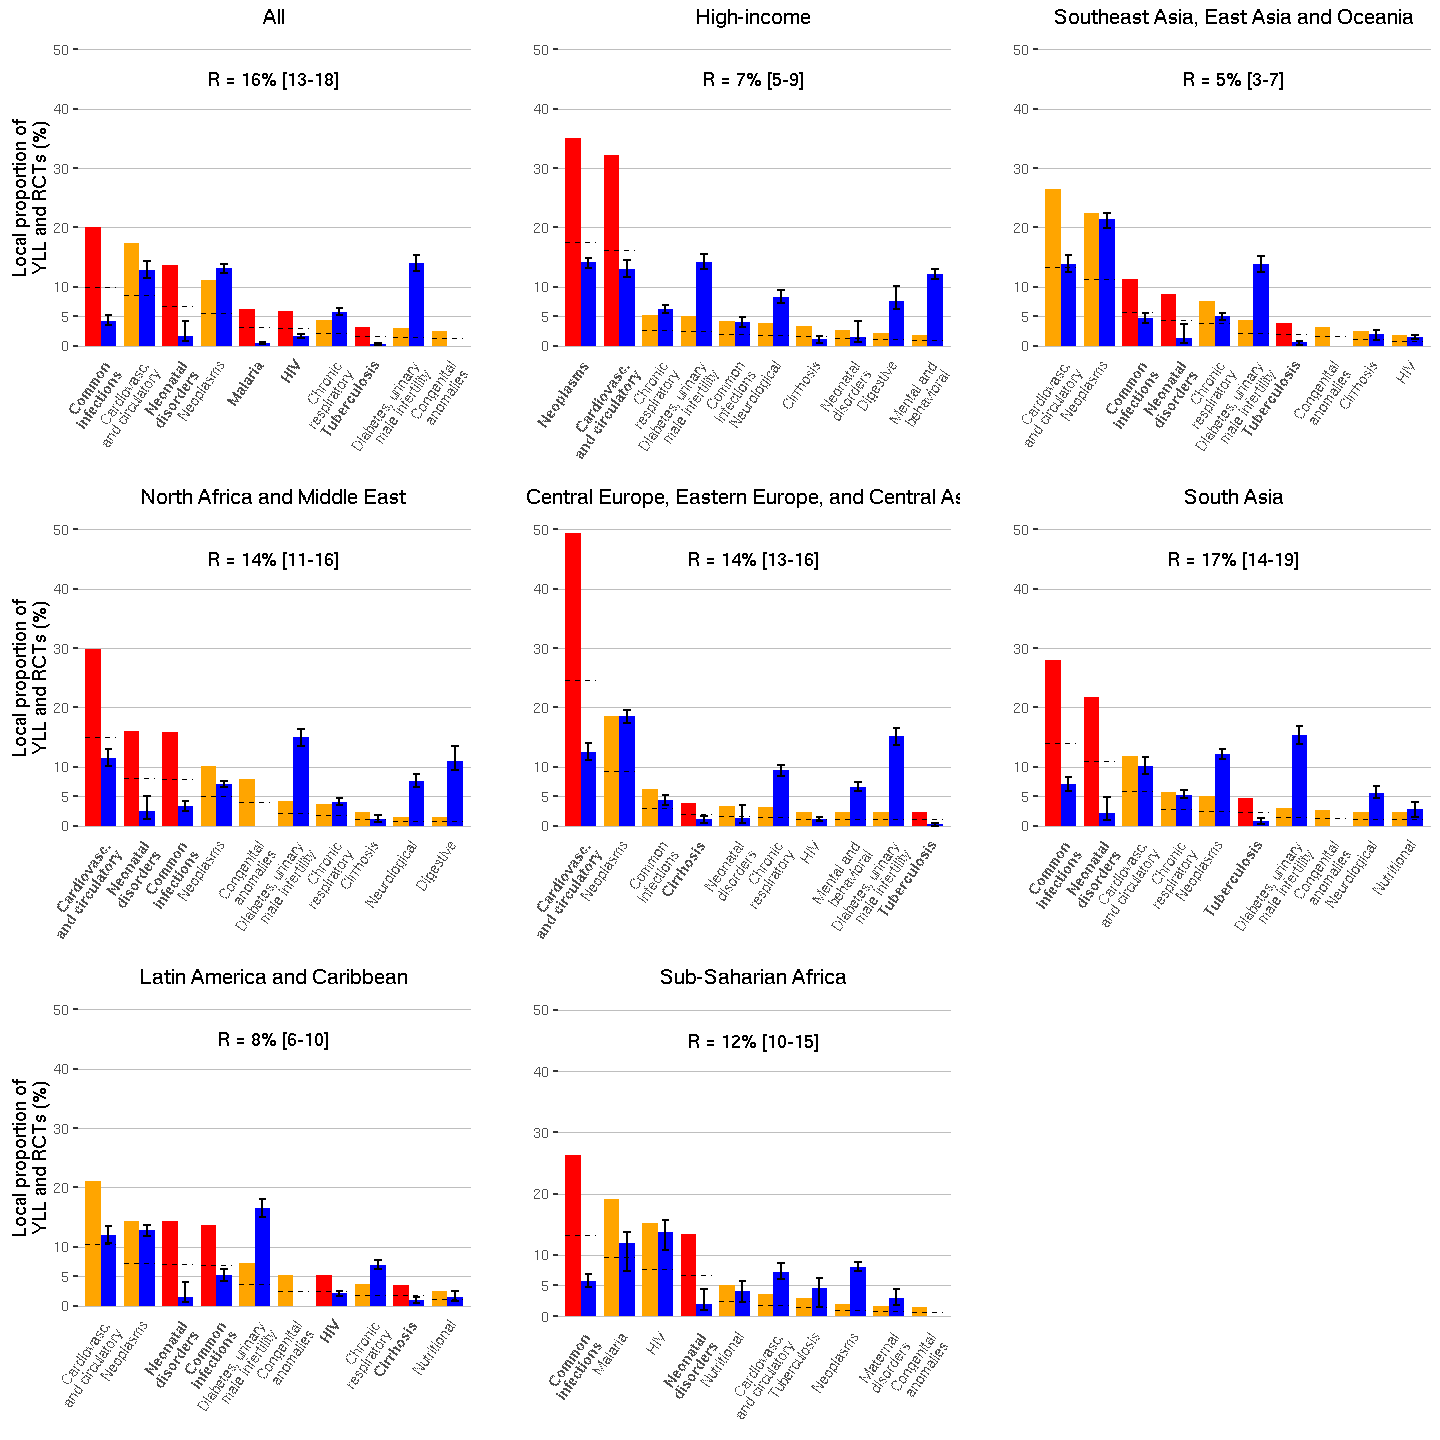

In [45]:
options(repr.plot.width=12, repr.plot.height=12)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3)

In [46]:
ggsave(filename = "../Figures/RCTs_vs_yll_allregions.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3),
       width=12,height=12)

Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

In [50]:
metr_burden <- "yld"
metr_res <- "RCTs"
max_plot <- 40

In [51]:
L <- list()
for(i in 1:length(regs)){

    r <- regs[i]
    
    dtp <- DT[DT$Region==r & DT$Disease!="All",c(which(names(DT)%in%c("Disease","Dis_lab")),
                        intersect(grep(metr_burden,names(DT)),grep("Prop_loc_burden",names(DT))),
                        intersect(grep(metr_res,names(DT)),grep("Prop_loc_",names(DT)))),]
    
    dfb <- dtp[,c(1,2,3)]
    names(dfb) <- c("Disease","Dis_lab","prop")
    dfb$mes <- "burden"
    dfr <- dtp[,c(1,2,5)]
    names(dfr) <- c("Disease","Dis_lab","prop")
    dfr$mes <- "research"
    dt <- rbind(dfb,dfr)

    dfre <- dtp[,c(1,2,4,6)]
    names(dfre) <- c("Disease","Dis_lab","prop_low","prop_up")
    dfre$mes <- "research"
    
    #10 Principales maladies
    diss <- dfb$Disease[order(dfb$prop,decreasing=TRUE)][1:10]
    dt <- droplevels(dt[dt$Disease%in%diss,])
    dfre <- droplevels(dfre[dfre$Disease%in%diss,])
    #Order of diseases
    dt$Disease <- reorder(dt$Disease,new.order=as.character(diss))
    dfre$Disease <- reorder(dfre$Disease,new.order=as.character(diss))
    
    #Highlighting GAPS
    dt$gap <- dt$Disease
    levels(dt$gap) <- unlist(lapply(levels(dt$Disease),
                                    function(x){
                                        ifelse(sum(dfre$Disease==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Disease==x]/
                                        dfre$prop_up[dfre$Disease==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Disease),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    #GGPLOT Object
    p <- ggplot(dt,aes(Disease))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Disease)-0.4,xend=as.numeric(Disease)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Disease)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Dis_lab
                              )

    if(i%%3==1){
    p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("Local proportion of\n",
                                           ifelse(metr_burden=="death",metr_burden,toupper(metr_burden)),
                                           " and ",
                                           metr_res,
                                           " (%)",sep="")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,max_plot),breaks=c(0,5,seq(10,max_plot,10)),
                                name=paste("\n")
                                )
        }
    p <- p + ggtitle(r)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(diss)+1)/2,y=max_plot-5,label=
            paste("R =",
             form(ratio_align[ratio_align$Region==r & ratio_align$metr==metr_burden,paste(metr_res,"nogap",sep="_")]))
            )
    
    L[[i]] <- p
}

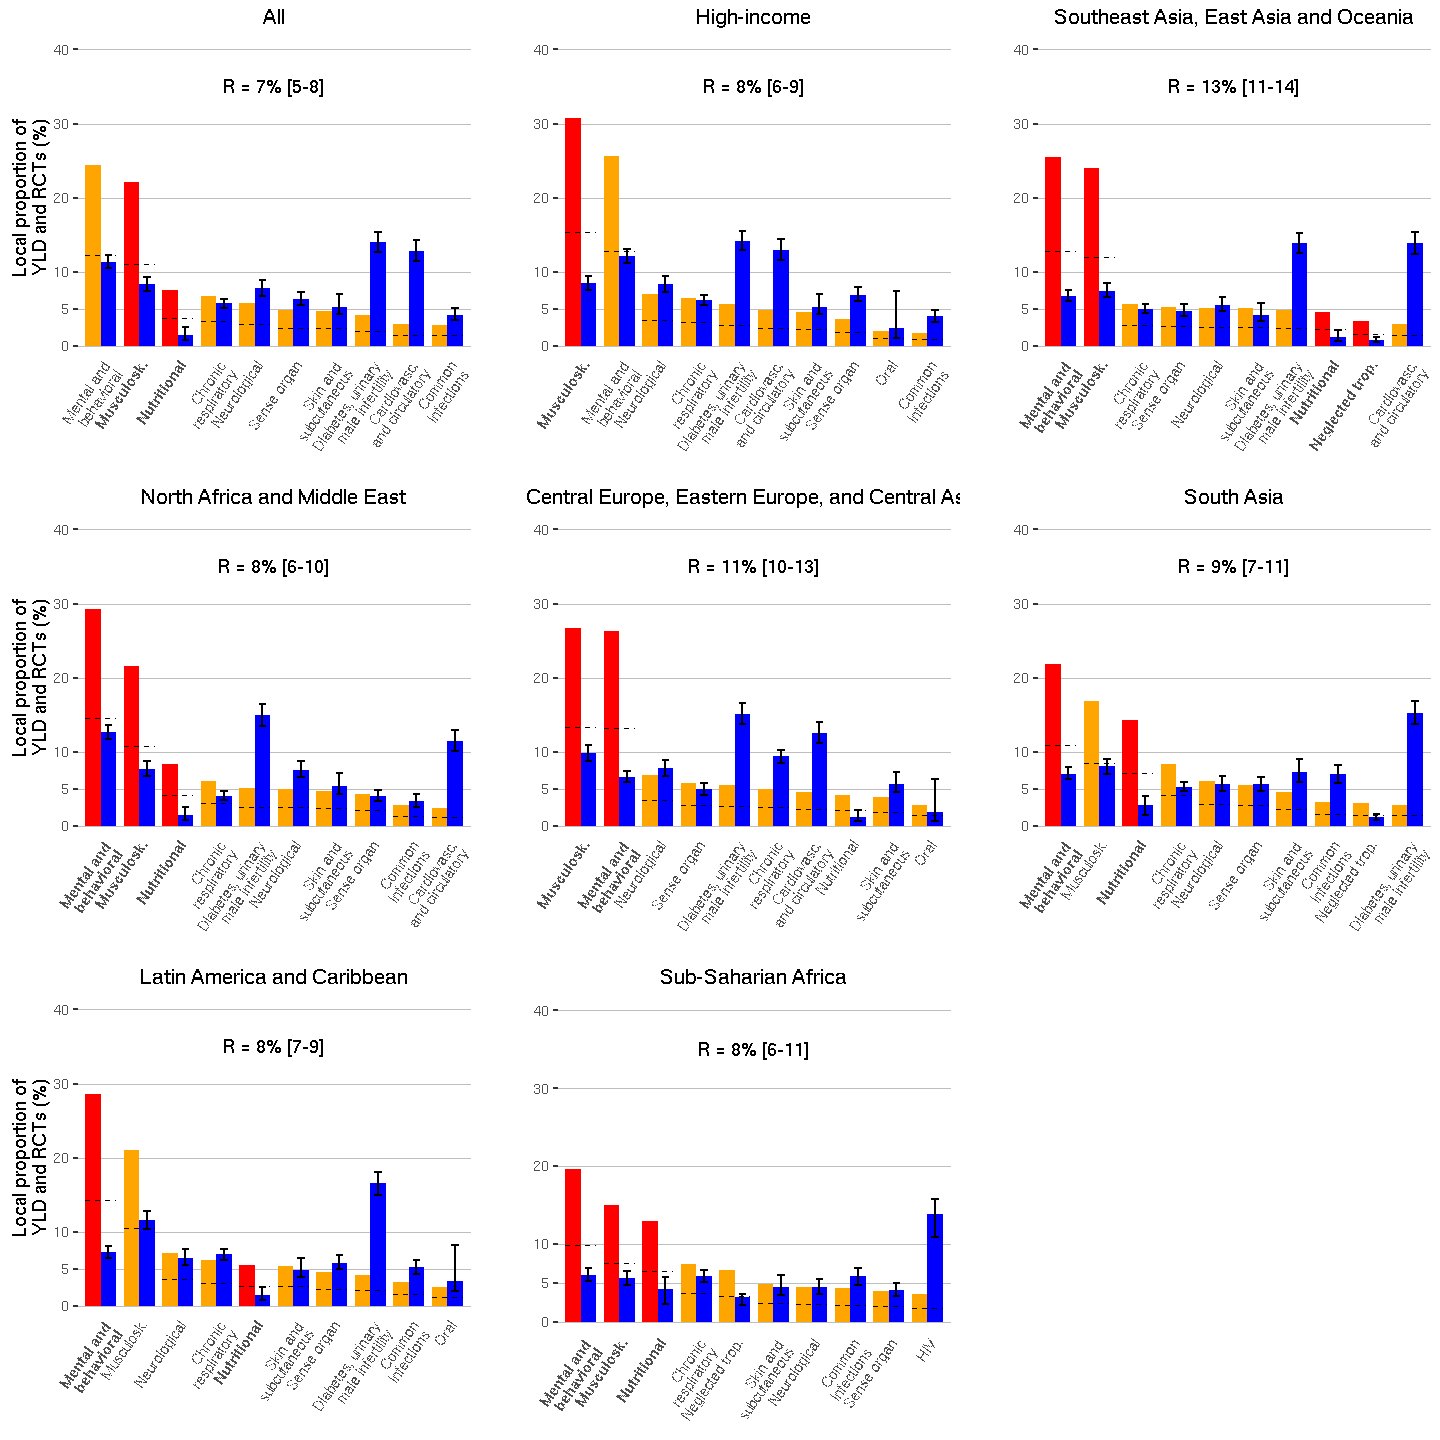

In [52]:
options(repr.plot.width=12, repr.plot.height=12)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3)

In [53]:
ggsave(filename = "../Figures/RCTs_vs_yld_allregions.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]], ncol=3),
       width=12,height=12)